In [24]:
import warnings
warnings.filterwarnings('ignore')

In [25]:
import pandas as pd 
import numpy as np
from statistics import mean
import seaborn as sns
import matplotlib.pyplot as plt
import re

The data from the previous notebook is loaded to check the performance of the Random forest on the sequence-based dataset.

In [26]:
proteins_with_functions= pd.read_csv("./Data/joined_tables.csv")

In [27]:
proteins_with_functions

,structureId,chainId,sequence,residueCount,len,A,C,D,E,F,...,T,U,V,W,Y,X,B,Z,classification,chainCount
0,101M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,154,0.110390,0.000000,0.038961,0.090909,0.032468,...,0.032468,0.0,0.058442,0.012987,0.019481,0.0,0.0,0.0,TRANSPORT PROTEIN,1
1,102L,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...,165,165,0.103030,0.000000,0.060606,0.048485,0.030303,...,0.072727,0.0,0.054545,0.018182,0.036364,0.0,0.0,0.0,HYDROLASE,1
2,102M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,154,0.116883,0.000000,0.038961,0.090909,0.038961,...,0.032468,0.0,0.051948,0.012987,0.019481,0.0,0.0,0.0,TRANSPORT PROTEIN,1
3,103L,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...,167,167,0.095808,0.000000,0.065868,0.047904,0.029940,...,0.071856,0.0,0.053892,0.017964,0.035928,0.0,0.0,0.0,HYDROLASE,1
4,103M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,154,0.116883,0.000000,0.038961,0.090909,0.038961,...,0.032468,0.0,0.051948,0.012987,0.019481,0.0,0.0,0.0,TRANSPORT PROTEIN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322737,9XIA,A,MNYQPTPEDRFTFGLWTVGWQGRDPFGDATRRALDPVESVQRLAEL...,388,388,0.121134,0.002577,0.095361,0.072165,0.059278,...,0.041237,0.0,0.048969,0.015464,0.023196,0.0,0.0,0.0,ISOMERASE,1
322738,9XIM,A,SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...,1572,393,0.117048,0.000000,0.083969,0.066158,0.055980,...,0.045802,0.0,0.050891,0.012723,0.030534,0.0,0.0,0.0,ISOMERASE,4
322739,9XIM,B,SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...,1572,393,0.117048,0.000000,0.083969,0.066158,0.055980,...,0.045802,0.0,0.050891,0.012723,0.030534,0.0,0.0,0.0,ISOMERASE,4
322740,9XIM,C,SVQATREDKFSFGLWTVGWQARDAFGDATRTALDPVEAVHKLAEIG...,1572,393,0.117048,0.000000,0.083969,0.066158,0.055980,...,0.045802,0.0,0.050891,0.012723,0.030534,0.0,0.0,0.0,ISOMERASE,4


The chains that are parts of the same protein have extremely similar sequences, and in general the same characteristics, to prevent data leakage that could occur if different chains of the same protein would end up in both train end test datasets, only the first (A) chain of the protein is used to make predictions.

In [28]:
proteins_cleaned = proteins_with_functions.drop_duplicates(subset="structureId",keep="first")

## Encoding predicted variable

For the encoding part, at the beginning, the classes are converted into numeric representations. While this may not always be the optimal solution, scikit-learn estimators handle label conversion automatically in classification tasks. When using other libraries, appropriate encoding must be considered, but for the base model, this approach should work well.

In [29]:
proteins_dict = dict(zip(list(proteins_cleaned["classification"].value_counts().index), range(len(proteins_cleaned["classification"].value_counts().index.tolist()))))

In [30]:
proteins_dict

{'HYDROLASE': 0,
 'TRANSFERASE': 1,
 'OXIDOREDUCTASE': 2,
 'BINDING PROTEIN': 3,
 'TRANSPORT PROTEIN': 4,
 'LYASE': 5,
 'IMMUNE SYSTEM': 6,
 'TRANSCRIPTION': 7,
 'SIGNALING PROTEIN': 8,
 'ISOMERASE': 9,
 'VIRAL PROTEIN': 10,
 'STRUCTURAL GENOMICS': 11,
 'LIGASE': 12,
 'MEMBRANE PROTEIN': 13,
 'REGULATORY PROTEIN': 14,
 'CELL ADHESION': 15,
 'STRUCTURAL PROTEIN': 16,
 'CHAPERONE': 17,
 'TOXIN': 18,
 'CELL CYCLE': 19,
 'HORMONE': 20,
 'RECEPTOR': 21,
 'VIRUS': 22,
 'APOPTOSIS': 23,
 'OXYGEN STORAGE': 24,
 'TRANSLATION': 25,
 'BIOSYNTHETIC PROTEIN': 26,
 'CYTOKINE': 27,
 'FLUORESCENT PROTEIN': 28,
 'MOTOR PROTEIN': 29,
 'CONTRACTILE PROTEIN': 30,
 'PHOTOSYNTHESIS': 31,
 'PROTEIN FIBRIL': 32}

In [31]:
proteins_cleaned["proteins_encoded"] = proteins_cleaned["classification"].map(proteins_dict)

In [32]:
proteins_cleaned.sort_values("len")

,structureId,chainId,sequence,residueCount,len,A,C,D,E,F,...,U,V,W,Y,X,B,Z,classification,chainCount,proteins_encoded
267507,5EFK,A,SDK,367,3,0.000000,0.000000,0.333333,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,HYDROLASE,2,0
266154,5DZK,1,XLL,5880,3,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.333333,0.0,0.0,HYDROLASE,56,0
21573,1LOC,1,XAX,944,3,0.333333,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.666667,0.0,0.0,BINDING PROTEIN,12,3
322641,8GCH,C,GAW,244,3,0.333333,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.333333,0.000000,0.000000,0.0,0.0,HYDROLASE,4,0
30629,1PVC,0,ISEV,882,4,0.000000,0.000000,0.000000,0.250000,0.000000,...,0.0,0.250000,0.000000,0.000000,0.000000,0.0,0.0,VIRUS,5,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273572,5GL0,A,MGDGGEGEDEVQFLRTDDEVVLQCSATVLKEQLKLCLAAEGFGNRL...,20580,5037,0.078221,0.019853,0.050427,0.095890,0.041096,...,0.0,0.063331,0.012905,0.028191,0.000000,0.0,0.0,TRANSPORT PROTEIN,8,4
273580,5GL1,A,MGDGGEGEDEVQFLRTDDEVVLQCSATVLKEQLKLCLAAEGFGNRL...,20580,5037,0.078221,0.019853,0.050427,0.095890,0.041096,...,0.0,0.063331,0.012905,0.028191,0.000000,0.0,0.0,TRANSPORT PROTEIN,8,4
281951,5J8V,A,MGDGGEGEDEVQFLRTDDEVVLQCSATVLKEQLKLCLAAEGFGNRL...,20148,5037,0.078221,0.019853,0.050427,0.095890,0.041096,...,0.0,0.063331,0.012905,0.028191,0.000000,0.0,0.0,TRANSPORT PROTEIN,4,4
273564,5GKZ,A,MGDGGEGEDEVQFLRTDDEVVLQCSATVLKEQLKLCLAAEGFGNRL...,20580,5037,0.078221,0.019853,0.050427,0.095890,0.041096,...,0.0,0.063331,0.012905,0.028191,0.000000,0.0,0.0,TRANSPORT PROTEIN,8,4


## Models

The results are checked with Random Forest the same way as in the 0_baseline_model notebook.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

df_size = len(proteins_cleaned)
train_size = int(len(proteins_cleaned)*0.7)

proteins_cleaned_cleaned = proteins_cleaned.sample(frac=1)

train = proteins_cleaned_cleaned[:train_size]
test = proteins_cleaned_cleaned[train_size:]

X_train = train.drop(columns=['structureId','chainId','sequence','classification',"proteins_encoded"])
y_train = train["proteins_encoded"]

X_test = test.drop(columns=['structureId','chainId','sequence','classification',"proteins_encoded"])
y_test = test["proteins_encoded"]

At the beginning, to balance the dataset, RandomOversampler or SMOTE were considered. Then after some attempts, these methods haven't really improved the classifier, instead class weights were added the model.

In [35]:
proteins_dict = dict(zip(
                         range(len(train["classification"].value_counts().index.tolist())), 
                         train["classification"].value_counts().values.tolist()))

In [36]:
dict_weights = dict()

count_val = len(X_train)
for key, value in proteins_dict.items():
    weight = 1-(value/count_val)
    dict_weights.update({key:weight})

In [ ]:
model = RandomForestClassifier(class_weight=dict_weights)
model.fit(X_train,y_train)

RandomForestClassifier(class_weight={0: 0.7804373989472276, 1: 0.83900849755042,
                                     2: 0.8834291688447464,
                                     3: 0.9170303553410569,
                                     4: 0.9386571682125968,
                                     5: 0.9593965401962096,
                                     6: 0.9630557142683476,
                                     7: 0.9665811643710719,
                                     8: 0.9720273769435563,
                                     9: 0.9758081182606159,
                                     10: 0.9768292831179567,
                                     11: 0.9782516198835386,
                                     12: 0.9791147473224814,
                                     13: 0.983223720200829,
                                     14: 0.9882930743140568,
                                     15: 0.9884267982834705,
                                     16: 0.9885848357018685,
                                     17: 0.9890346345080782,
                                     18: 0.9890711046815546,
                                     19: 0.9932530179068552,
                                     20: 0.9933502717027924,
                                     21: 0.9934839956722061,
                                     22: 0.9948212353663429,
                                     23: 0.9955020119379034,
                                     24: 0.9959153405706367,
                                     25: 0.9960004376420817,
                                     26: 0.9962921990298934,
                                     27: 0.9967176843871187,
                                     28: 0.9967419978361031,
                                     29: 0.9975564983770773, ...})

In [38]:
y_pred = model.predict(X_test)

The results are promising with all metrics at about 0.7 which proves that the sequences provide valuable information about the protein functions. And it proves that protein function can be predicted with some accuracy only based on the simple characteristics - without complex study of the sequence

In [39]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


print(f"accuracy: {accuracy_score(y_test, y_pred)}")
print(f"F1: {f1_score(y_test, y_pred, average='macro')}")
print(f"precision: {precision_score(y_test, y_pred, average='macro')}")
print(f"recall: {recall_score(y_test, y_pred, average='macro')}")

accuracy: 0.7638282180745447
F1: 0.6903002781388065
precision: 0.7970237027114997
recall: 0.6257537809904685


In [40]:
print(f"accuracy: {accuracy_score(y_test, y_pred)}")
print(f"F1: {f1_score(y_test, y_pred, average='weighted')}")
print(f"precision: {precision_score(y_test, y_pred, average='weighted')}")
print(f"recall: {recall_score(y_test, y_pred, average='weighted')}")

accuracy: 0.7638282180745447
F1: 0.7575760665117087
precision: 0.776214536159541
recall: 0.7638282180745447


The plot visualises that the predictions are mainly accurate, with the most problematic area on the left side of the plot - which indicates that some of the samples from the less represented groups being classified as hydrolase, transferase, oxidoreductase and other more populated groups. 
These groups were represented with more samples in the train dataset and there were more data describing these groups, so this result is not very surprising even considering using the weights during training. 

The most inaccurate are predictions about proteins related to structural genomics, while the most accurate are well-represented groups and fluorescent proteins (which probably can have very typical characteristics different from other proteins)

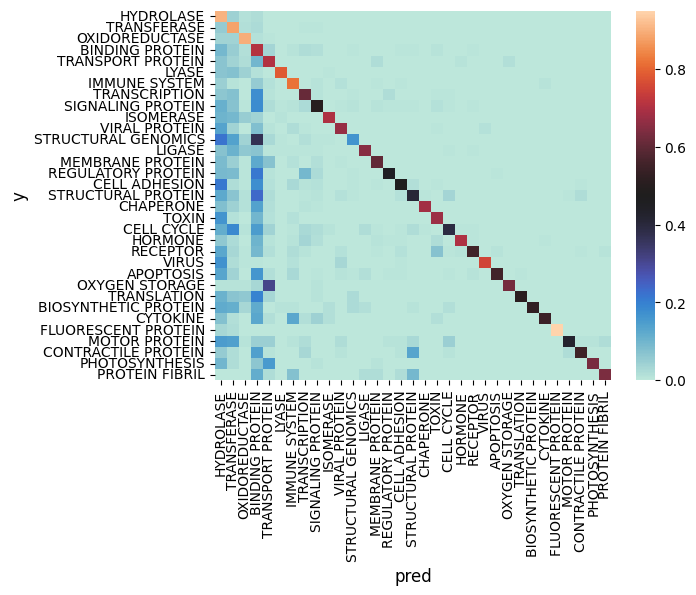

In [ ]:
from sklearn.metrics import confusion_matrix

names = list(proteins_cleaned["classification"].value_counts().index)

cm = confusion_matrix(y_test, y_pred)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn,  cmap='icefire', xticklabels=names, yticklabels=names)
plt.ylabel('y',fontsize=12)
plt.xlabel('pred',fontsize=12)
plt.show()